In [ ]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# this makes sure cached files are readily available (for calling e.g. `gather_data_cached`)
!apt-get install git-lfs
!git lfs install

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Git LFS initialized.
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 787, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 787 (delta 86), reused 79 (delta 26), pack-reused 620 (from 1)
Receiving objects: 100% (787/787), 26.84 MiB | 8.33 MiB/s, done.
Resolving deltas: 100% (440/440), done.
Updating files: 100% (111/111), done.
Filtering content: 100% (32/32), 1.75 GiB | 51.98 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [ ]:
!pip install ta
!pip install pykalman

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=88aa83d7ab3b2bb0ef5c6fe14f49dc172e8a1ec29ce5446782661dc07b74a0bb
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 9.8 MB/s eta 0:00:00


In [ ]:
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else
import torch.nn as nn
import itertools
from pykalman import KalmanFilter
import ast
import re
from tabulate import tabulate
from datetime import datetime

# Custom Imports
from models.statistical_models import create_dataset, default_normalize, rmse_metric, acc_metric, kalman_filter_average, kalman_filter_regression, kalman_filter_regression_multivariate
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.wavelet_denoising import wav_den
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade, get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty
from utils.visualization import plot_return_uncertainty, plot_comparison
from utils.helpers import _get_train_dev_frac

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, _get_filename, gather_pairs_data_cached, gather_data_cached_using_truncate

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

In [ ]:
startDateStr = '2008-01-01'
end_year = 2024
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01'
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)


instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data)

i = 0
ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
output = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
output

{'gt_yoy_test': np.float64(0.01320367295159719),
 'gt_yoy_dev': np.float64(-0.006013833026988102)}

In [ ]:
# test: see whether the original trading function does give profitable results, and whether this differs from my new trading function
seed = 3178749
from sklearn.metrics import mean_squared_error
np.random.seed(seed)  # For reproducibility

def trade_original(S1, S2, spread, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ma1 = spread.rolling(window=window1, center=False).mean()
    ma2 = spread.rolling(window=window2, center=False).mean()
    std = spread.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(spread)):
        # Sell short if the z-score is > 1
        if zscore.iloc[i] > 1:
            # print(f"[OLD] Step {i}: SELL SHORT, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, money={money:.2f}, countS1={countS1}, countS2={countS2}")
            money += S1.iloc[i] - S2.iloc[i] * spread.iloc[i]
            countS1 -= 1
            countS2 += spread.iloc[i]
        # Buy long if the z-score is < 1
        elif zscore.iloc[i] < -1:
            # print(f"[OLD] Step {i}: BUY LONG, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, money={money:.2f}, countS1={countS1}, countS2={countS2}")
            money -= S1.iloc[i] - S2.iloc[i] * spread.iloc[i]
            countS1 += 1
            countS2 -= spread.iloc[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore.iloc[i]) < 0.5:
            # print(f"[OLD] Step {i}: CLEAR POSITION, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, money={money:.2f}, countS1={countS1}, countS2={countS2}")
            money += countS1 * S1.iloc[i] - S2.iloc[i] * countS2
            countS1 = 0
            countS2 = 0
    return money

def trade(
        S1: pd.Series,
        S2: pd.Series,
        spread: pd.Series, # model-predicted spread for the strategy
        window_long: int,
        window_short: int,
        position_threshold: float = 1.0,
        clearing_threshold: float = 0.5,
        risk_fraction: float = 0.1 # could be used again
    ):
        if len(spread) != len(S1) or len(spread) != len(S2):
            raise ValueError("Length of S1, S2, and spread must be the same")
        # Compute rolling mean and rolling standard deviation

        ma_long = spread.rolling(window=window_long, center=False).mean()
        ma_short = spread.rolling(window=window_short, center=False).mean()
        std = spread.rolling(window=window_short, center=False).std()
        zscore = (ma_long - ma_short)/std

        # Calculate initial cash based on average range of S1, S2 and Spread_Close, as these also determine the size of the trades
        s2_spread = max(S2) - min(S2)
        s1_spread = max(S1) - min(S1)
        spread_spread = max(spread) - min(spread)
        avg_spread = (s2_spread + s1_spread + spread_spread) / 3
        initial_cash = avg_spread * len(spread) # the absolute returns are correlated to the length of the spread, times the average range.

        # Simulate trading
        # Start with no money and no positions
        cash = initial_cash # initial cash amount, perhaps not hardcoded in the future
        qty_s1 = 0
        qty_s2 = 0
        returns = [initial_cash]

        for i in range(len(spread)):
            # Sell short if the z-score is > 1
            if zscore.iloc[i] > position_threshold:
                # print(f"[NEW] Step {i}: SELL SHORT, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, cash={cash:.2f}, qty_s1={qty_s1}, qty_s2={qty_s2}")
                cash +=  S1.iloc[i] - S2.iloc[i] * spread.iloc[i]
                qty_s1 -= 1
                qty_s2 += spread.iloc[i]
            # Buy long if the z-score is < 1
            elif zscore.iloc[i] < -position_threshold:
                # print(f"[NEW] Step {i}: BUY LONG, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, cash={cash:.2f}, qty_s1={qty_s1}, qty_s2={qty_s2}")
                cash -=  S1.iloc[i] - S2.iloc[i] * spread.iloc[i]
                qty_s1 += 1
                qty_s2 -= spread.iloc[i]
            # Clear positions if the z-score between -.5 and .5
            elif abs(zscore.iloc[i]) < clearing_threshold:
                # print(f"[NEW] Step {i}: CLEAR POSITION, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, cash={cash:.2f}, qty_s1={qty_s1}, qty_s2={qty_s2}")
                cash += qty_s1 * S1.iloc[i] - S2.iloc[i] * qty_s2
                qty_s1 = 0
                qty_s2 = 0
            returns.append(cash) # append the current cash value to returns
        # If at any point returns is 0, all values after that is zero
        zero_from_this_idx = -1
        for i in range(len(returns)):
            if returns[i] <= 0:
                zero_from_this_idx = i
                break
        if zero_from_this_idx > -1:
          returns[zero_from_this_idx:] = [0] * (len(returns) - zero_from_this_idx)

        # Shrink returns by a factor such that returns are not inflated.
        returns_series = pd.Series(returns)
        alpha = 0.1  # Shrinking/stretching factor
        returns_uninflated = returns_series[0] + alpha * (returns_series - returns_series[0])
        # turn back into list
        returns_uninflated = returns_uninflated.tolist()
        return returns_uninflated

mse_list = []
profit_original_method_list = []
profit_new_method_list = []
profit_new_method_absolute_list = []
profit_original_method_std_dev_list = []
profit_new_method_std_dev_list = []
profit_new_method_absolute_std_dev_list = []
for std_dev in tqdm(np.linspace(0.01, 4, num=10)):
  mse_sum = 0
  profit_sum = 0
  profit_new_sum = 0
  profit_new_absolute_sum = 0
  num_pairs = min(len(pairs_data_filtered), 10)

  for i in range(num_pairs):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
    pairs_timeseries_df = combine_pairs_data(
        data_close_filtered_2, data_open_filtered_2, data_high_filtered_2,
        data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b
    )

    # add random noise to simulate prediction
    noise = np.random.normal(0, std_dev, size=len(pairs_timeseries_df))
    pairs_timeseries_df_spread_close_noise = pairs_timeseries_df['Spread_Close'] + noise
    mse = mean_squared_error(pairs_timeseries_df['Spread_Close'], pairs_timeseries_df_spread_close_noise)

    max_length = 300
    profit = trade_original(pairs_timeseries_df['S1_close'].iloc[:max_length], pairs_timeseries_df['S2_close'].iloc[:max_length], pairs_timeseries_df_spread_close_noise.iloc[:max_length], 30, 5)
    profit_new = trade(pairs_timeseries_df['S1_close'].iloc[:max_length], pairs_timeseries_df['S2_close'].iloc[:max_length], pairs_timeseries_df_spread_close_noise.iloc[:max_length], 30, 5)
    yoy_return = ((profit_new[-1] - profit_new[0]) / profit_new[0])**(365 / len(pairs_timeseries_df['S1_close'].iloc[:max_length])) - 1

    mse_sum += mse
    profit_sum += profit
    profit_new_sum += yoy_return
    profit_new_absolute_sum += profit_new[-1]

  mse_list.append(mse_sum / num_pairs)
  profit_original_method_list.append(profit_sum / num_pairs)
  profit_new_method_list.append(profit_new_sum / num_pairs)
  profit_new_method_absolute_list.append(profit_new_absolute_sum / num_pairs)
  profit_original_method_std_dev_list.append(np.std(profit_original_method_list))
  profit_new_method_std_dev_list.append(np.std(profit_new_method_list))
  profit_new_method_absolute_std_dev_list.append(np.std(profit_new_method_absolute_list))

  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-15-0531171a6bc4>:140: RuntimeWarning: invalid value encountered in scalar power
  yoy_return = ((profit_new[-1] - profit_new[0]) / profit_new[0])**(365 / len(pairs_timeseries_df['S1_close'].iloc[:max_length])) - 1


In [ ]:
((profit_new[-1] - profit_new[0]) / profit_new[0])**(365 / len(pairs_timeseries_df['S1_close'].iloc[:max_length])) - 1

np.float64(0.06876003077892778)

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


TypeError: float() argument must be a string or a real number, not 'complex'

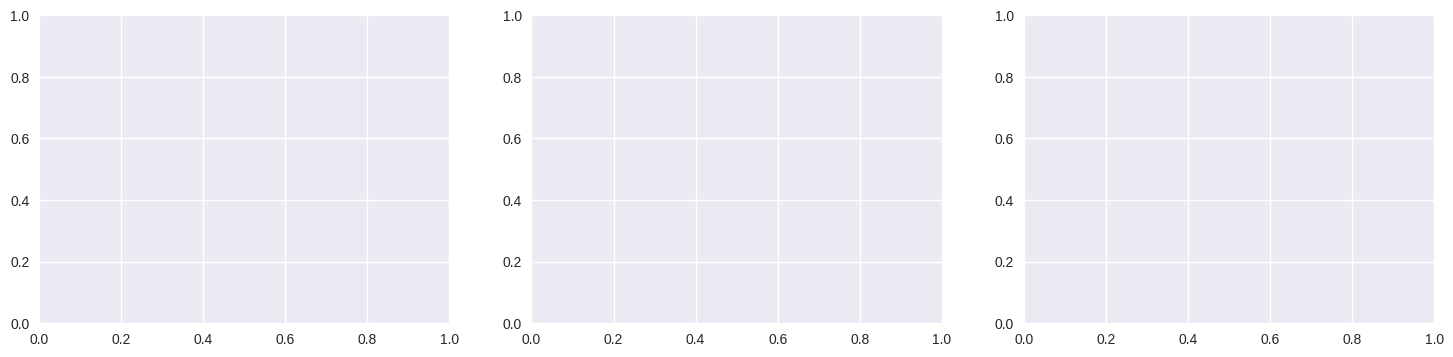

In [ ]:
from scipy.optimize import curve_fit
np.random.seed(3178749)  # For reproducibility


# Goal: x-axis MSE (artificially added noise), y-axis yoy returns
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# For axs[0]: New Method
# coeffs0 = np.polyfit(mse_list, profit_new_method_list, 2)
# x0 = np.linspace(min(mse_list), max(mse_list), 100)
# def logarithmic(x, a, b, c):
#     return a * np.log(x + b) + c
# popt_log, _ = curve_fit(logarithmic, mse_list, profit_new_method_list, p0=[-1e5, 2, 2e5], maxfev=5000)
# y0 = logarithmic(x0, *popt_log)
# axs[0].plot(x0, y0, color="purple", label="Logarithmic Fit")

axs[0].errorbar(
    mse_list,
    profit_new_method_list,
    yerr=profit_new_method_std_dev_list,
    fmt='o',
    label="New Method",
    alpha=0.5,
    capsize=3
)
axs[0].set_title("New Method")
axs[0].set_xlabel("MSE (Artificially Added Noise)")
axs[0].set_ylabel("YoY Returns")

coeffs1 = np.polyfit(mse_list, profit_new_method_absolute_list, 2)
x1 = np.linspace(min(mse_list), max(mse_list), 100)
def logarithmic(x, a, b, c):
    return a * np.log(x + b) + c
popt_log, _ = curve_fit(logarithmic, mse_list, profit_new_method_absolute_list, p0=[-1e5, 2, 2e5], maxfev=5000)
y1 = logarithmic(x1, *popt_log)
axs[1].plot(x1, y1, color="purple", label="Logarithmic Fit")

axs[1].errorbar(
    mse_list,
    profit_new_method_absolute_list,
    yerr=profit_new_method_absolute_std_dev_list,
    fmt='o',
    label="New Method",
    alpha=0.5,
    capsize=3
)
axs[1].set_title("New Method (absolute)")
axs[1].set_xlabel("MSE (Artificially Added Noise)")
axs[1].set_ylabel("Absolute Returns")


# For axs[1]: Old Method
coeffs2 = np.polyfit(mse_list, profit_original_method_list, 2)
x2 = np.linspace(min(mse_list), max(mse_list), 100)
def logarithmic(x, a, b, c):
    return a * np.log(x + b) + c
popt_log, _ = curve_fit(logarithmic, mse_list, profit_original_method_list, p0=[-1e5, 2, 2e5], maxfev=5000)
y2 = logarithmic(x2, *popt_log)
axs[2].plot(x2, y2, color="purple", label="Logarithmic Fit")

axs[2].errorbar(
    mse_list,
    profit_original_method_list,
    yerr=profit_original_method_std_dev_list,
    fmt='o',
    label="Original Method",
    alpha=0.5,
    capsize=3
)
axs[2].set_title("Old Method")
axs[2].set_xlabel("MSE (Artificially Added Noise)")
axs[2].set_ylabel("Total Returns")

In [ ]:
# Plot all profits for std dev = 0.01

FileNotFoundError: [Errno 2] No such file or directory: 'mse_list_2008_2023_full.pkl'

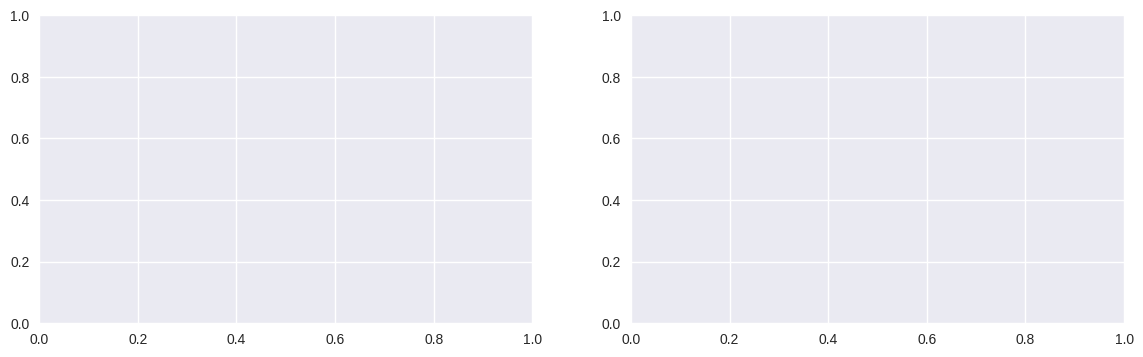

In [ ]:
import pickle

fig, axs = plt.subplots(1, 2, figsize=(14, 4))

for i, end_year in enumerate([2023, 2024]):
  save_hash = f"2008_{end_year}_full"
  mse_list_filename = f'mse_list_{save_hash}.pkl'
  profit_new_method_list_filename = f'profit_new_method_list_{save_hash}.pkl'
  profit_new_method_std_dev_list_filename = f'profit_new_method_std_dev_list_{save_hash}.pkl'

  with open(mse_list_filename, 'rb') as f:
      mse_list = pickle.load(f)
  with open(profit_new_method_list_filename, 'rb') as f:
      profit_new_method_list = pickle.load(f)
  with open(profit_new_method_std_dev_list_filename, 'rb') as f:
      profit_new_method_std_dev_list = pickle.load(f)

  axs[i].errorbar(
      mse_list,
      profit_new_method_list,
      yerr=profit_new_method_std_dev_list,
      fmt='o',
      alpha=0.5,
      capsize=3
  )
  axs[i].set_title(f"YoY returns for pairs trading strategy across top 30 pairs (2008-{end_year})")
  axs[i].set_xlabel("MSE (Artificially Added Noise)")
  axs[i].set_ylabel("Average YoY Returns")

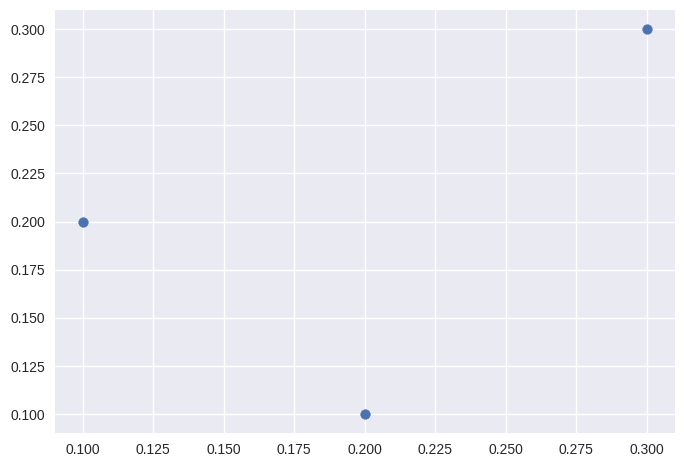

In [ ]:
test_mse = [0.1,0.2,0.3]
val_mse = [0.2,0.1,0.3]

plt.scatter(test_mse, val_mse)